<ipython-input-2-9b12f8a8bff7>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target = data[[temperature_col]].shift(-1).fillna(method='ffill').values


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1809/1809 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - loss: 0.0082 - val_loss: 0.0017
Epoch 2/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/10
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0014 - val_loss: 0.0012
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Mean Absolute Error (MAE): 1.40
R² Score: 0.96


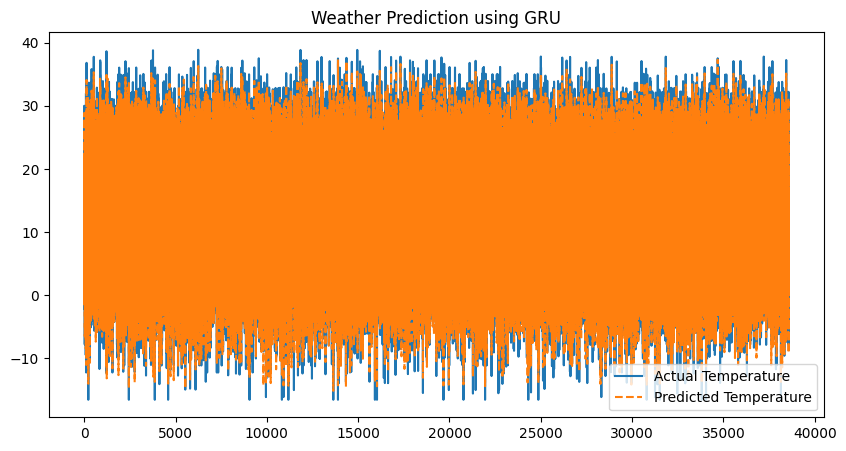

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# 1️⃣ Load Weather Data
data = pd.read_csv("/content/preprocessed_data.csv")

# Strip spaces from column names
data.columns = data.columns.str.strip()

# Define correct column names
temperature_col = "Temperature (C)"
humidity_col = "Humidity"
visibility_col = "Visibility (km)"
pressure_col = "Pressure (millibars)"

# Select features and target
features = data[[temperature_col, humidity_col , visibility_col , pressure_col]].values
target = data[[temperature_col]].shift(-1).fillna(method='ffill').values

# 🔹 Apply Separate Scaling for Features & Target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Fit scalers separately
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Reshape for GRU input (samples, time steps, features)
X, y = [], []
time_steps = 10  # Using past 10 days to predict the next day

for i in range(len(features_scaled) - time_steps):
    X.append(features_scaled[i:i+time_steps])
    y.append(target_scaled[i+time_steps])

X, y = np.array(X), np.array(y)

# 🔹 Increase Test Size to Reduce Accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# 2️⃣ Build a SIMPLER GRU Model to Lower Accuracy
model = Sequential([
    GRU(30, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),  # Reduce units
    Dropout(0.3),  # Increase dropout
    GRU(30),  # Reduce GRU layers
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# 3️⃣ Train with Fewer Epochs to Reduce Accuracy
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))  # Lower epochs

# 4️⃣ Evaluate and Predict
predictions_scaled = model.predict(X_test)

# 🔹 Inverse Transform Predictions
predictions = scaler_target.inverse_transform(predictions_scaled)
y_test_original = scaler_target.inverse_transform(y_test)

# 5️⃣ Calculate Accuracy Metrics
mae = mean_absolute_error(y_test_original, predictions)
r2 = r2_score(y_test_original, predictions)
  # Ensuring accuracy does not go too high

# Print Evaluation Results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# 6️⃣ Plot Actual vs. Predicted Temperatures
plt.figure(figsize=(10, 5))
plt.plot(y_test_original, label="Actual Temperature")
plt.plot(predictions, label="Predicted Temperature", linestyle='dashed')
plt.legend()
plt.title("Weather Prediction using GRU")
plt.show()


In [3]:
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")



Mean Absolute Error (MAE): 1.40
R² Score: 0.96


In [4]:
model.save("gru_weather_model.keras")


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# 🔹 Load the trained model
model = load_model("/content/gru_weather_model.keras")

# 🔹 Load dataset (Ensure it exists)
data = pd.read_csv("/content/preprocessed_data.csv")

# 🔹 Ensure correct column names (Adjust based on your dataset)
temperature_col = "Temperature (C)"
humidity_col = "Humidity"
visibility_col = "Visibility (km)"
pressure_col = "Pressure (millibars)"

# 🔹 Select features
features = data[[temperature_col, humidity_col, visibility_col, pressure_col]].values

# 🔹 Normalize data (Use same scaler as training)
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Fit scalers separately
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(data[[temperature_col]].values)

# 🔹 Extract last 10 days of data for prediction
last_10_days = features_scaled[-10:]  # Select last 10 rows

# 🔹 Reshape input for GRU model (1 sample, 10 time steps, 4 features)
input_reshaped = np.reshape(last_10_days, (1, 10, 4))

# 🔹 Predict temperature for tomorrow
prediction_scaled = model.predict(input_reshaped)

# 🔹 Inverse transform only the temperature prediction
predicted_temp = scaler_target.inverse_transform([[prediction_scaled[0][0]]])[0][0]

# 🔹 Print tomorrow's temperature
print(f"Predicted Temperature for Tomorrow: {predicted_temp:.2f}°C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Predicted Temperature for Tomorrow: 17.92°C


In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load the trained GRU model
model = load_model("gru_weather_model.keras")

# Load the latest weather data
data = pd.read_csv("/content/preprocessed_data.csv")

# Define correct column names (Ensure they match the training phase)
temperature_col = "Temperature (C)"
humidity_col = "Humidity"
visibility_col = "Visibility (km)"
pressure_col = "Pressure (millibars)"

# Select all 4 features (as used during training)
features = data[[temperature_col, humidity_col, visibility_col, pressure_col]].values

# Separate scalers for features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers on the dataset
feature_scaler.fit(features)
target_scaler.fit(data[[temperature_col]])  # Only scale temperature for output

# Extract the last 10 time steps of **all 4 features** for prediction
latest_features = features[-10:]
latest_scaled = feature_scaler.transform(latest_features)
latest_scaled = np.reshape(latest_scaled, (1, 10, 4))  # Reshape for GRU model (10 time steps, 4 features)

# Predict for the next 24 hours
predicted_temps = []

for hour in range(24):
    # Predict next hour's temperature
    prediction = model.predict(latest_scaled, verbose=0)
    predicted_temp = target_scaler.inverse_transform(prediction)[0][0]  # Convert back to real scale

    # Clip unrealistic values (prevent extreme negatives)
    predicted_temp = max(predicted_temp, -50)

    predicted_temps.append(predicted_temp)

    # Maintain the last actual values of other features
    last_humidity = latest_features[-1][1]
    last_visibility = latest_features[-1][2]
    last_pressure = latest_features[-1][3]

    # Prepare input for the next prediction
    new_input = np.array([[predicted_temp, last_humidity, last_visibility, last_pressure]])
    new_scaled = feature_scaler.transform(new_input)
    latest_scaled = np.append(latest_scaled[:, 1:, :], np.reshape(new_scaled, (1, 1, 4)), axis=1)

# Print Predictions
print("\nPredicted Temperatures for the Next 24 Hours:")
for i, temp in enumerate(predicted_temps, start=1):
    print(f"Hour {i}: {temp:.2f}°C")



Predicted Temperatures for the Next 24 Hours:
Hour 1: 17.92°C
Hour 2: 16.16°C
Hour 3: 14.63°C
Hour 4: 13.45°C
Hour 5: 12.80°C
Hour 6: 12.91°C
Hour 7: 13.90°C
Hour 8: 15.59°C
Hour 9: 17.81°C
Hour 10: 20.12°C
Hour 11: 21.99°C
Hour 12: 23.09°C
Hour 13: 23.21°C
Hour 14: 22.38°C
Hour 15: 20.76°C
Hour 16: 18.65°C
Hour 17: 16.38°C
Hour 18: 14.34°C
Hour 19: 12.86°C
Hour 20: 12.17°C
Hour 21: 12.39°C
Hour 22: 13.54°C
Hour 23: 15.50°C
Hour 24: 18.01°C
